# Synthetic Data Generation Using Graphic Model

Due to privacy protection, socioeconomical data is released at aggregated regional levels, but practitioners often find individual level data far more appealing, as aggregated data lacks information such as variances and distributions of residents within that region. In order to utilize privacy-protected data, aggregated data needs to be downscaled at individual level. In this project, a synthetic dataset is generated from a demographic dataset at individual level and TransUnion dataset at aggregated level by using graphic model, more specifically, Gaussian Copula model. 

## Methods for Synthetic Data Generation

### 1. Grahpic Model -- A Machine Learning Approach
    
It is a probabilistic model for which a graph expresses the conditional dependence structure between random variables, and the method used in this project.

### 2. Generative adversarial network (GAN) -- A Deep Learning Approach

GANs can be used to produce new data. It discovers structure in the data that allows them to make realistic data. It is useful if we cannot see that structure on our own or cannot pull it out with other methods. Although GAN is capable of synthetic data generaton, it can only augment original data, meaning the output of the model is the same shape as the original input data. It lacks the ability to downscale aggregated data. 


### Table of Contents
* [1. TransUnion Data (Aggregated Dataset)](#1.-TransUnion-Data-(Aggregated-Dataset))
    * [1.1 Load Data](#1.1-Load-Data)
    * [1.2 Data Preprocessing](#1.2-Data-Preprocessing)
* [2. Demographic Data (Individual Dataset)](#2.-Demographic-Data-(Individual-Dataset))
    * [2.1 Load Data](#1.1-Load-Data)
    * [2.2 Data Preprocessing](#2.2-Data-Preprocessing)
* [3. Merge Two Datasets](#3.-Merge-Two-Preprocessed-Datasets)
* [4. Synthetic Data Generation Using Gaussian Copula](#4.-Synthetic-Data-Generation-Using-Gaussian-Copula)
    * [4.1 Sample from Normal Distribution](#4.1-Sample-from-Normal-Distribution)
    * [4.2 Uniformify Marginal Distribution](#4.2-Uniformify-Marginal-Distribution)
    * [4.3 Convert Uniform Distribution into Desired Marginal Distribution](#4.3-Convert-Uniform-Distribution-into-Desired-Marginal-Distribution)
        * [4.3.1 Continuous Data Conversion](#4.3.1-Continuous-Data-Conversion)
        * [4.3.2 Categorical Data Conversion](#4.3.2-Categorical-Data-Conversion)
        * [4.3.3 Class Assignment with Multinomial Distribution](#4.3.3-Class-Assignment-with-Multinomial-Distribution)

In [25]:
from functools import partial
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from utils import expand_df, composite_SD, create_transunion_csv

# 1. TransUnion Data (Aggregated Dataset)

## 1.1 Load Data
There are hundreds of variables in this dataset. To select a variable, both IndustryCategory and IndustryVariableNum need to be specified. 

In [3]:
# TransUnion Data is in parquet format, which is ouput from Hadoop. Need to convert it to csv
# for data processing.
# create_transunion_csv()

data = []
for i in range(10): # There are ten partitions in the transunion data.
    df = pd.read_csv("./data/transunion_{}.csv".format(i))
    df = df.loc[(df["IndustryCategory"] == "AT") & (df["IndustryVariableNum"] == 1)]
    data.append(df)

data = pd.concat(data)

**The following DataFrame contains statistical data for the variable "Number of Trade per Month" in street level**

In [4]:
data.head()

,Unnamed: 0,PostalCd,IndustryCategory,IndustryVariableNum,Count,Sum,Min,Max,Mean,Median,StdDev
17871,17871,P0R1C0,AT,1,15,166,2,24,11.07,10.0,7.01
17889,17889,P0R1C0,AT,1,15,128,1,22,8.53,7.0,5.49
17891,17891,V0N3A0,AT,1,18,216,1,35,12.00,9.5,9.75
17903,17903,J0P1Z0,AT,1,15,191,1,24,12.73,13.0,7.29
17912,17912,J0P1Z0,AT,1,16,193,1,29,12.06,11.0,8.90


## 1.2 Data Preprocessing

In [5]:
duplicates_df = data[data.duplicated(["PostalCd"])]
duplicates_df.loc[duplicates_df["PostalCd"] == "A0G3K0"]

,Unnamed: 0,PostalCd,IndustryCategory,IndustryVariableNum,Count,Sum,Min,Max,Mean,Median,StdDev
32461318,4137,A0G3K0,AT,1,15,157,1,24,10.47,7.0,7.56
32461353,4172,A0G3K0,AT,1,15,182,1,30,12.13,12.0,7.81
32461720,4539,A0G3K0,AT,1,14,145,1,24,10.36,7.5,7.88
32461747,4566,A0G3K0,AT,1,12,93,1,19,7.75,6.5,5.17
32482237,25056,A0G3K0,AT,1,15,201,1,28,13.40,13.0,7.66
32482267,25086,A0G3K0,AT,1,15,167,1,37,11.13,9.0,10.20
32482308,25127,A0G3K0,AT,1,12,149,1,27,12.42,11.0,6.68
32482528,25347,A0G3K0,AT,1,15,139,2,18,9.27,8.0,4.89
32482561,25380,A0G3K0,AT,1,15,167,2,28,11.13,9.0,7.52
32499943,42762,A0G3K0,AT,1,14,102,1,20,7.29,6.5,6.04


**In order to join TransUnion Data with Demographic data, this dataset needs to be aggregated to Postal level**

In [6]:
def aggregate_group(x):
    d = {}
    d["Count"] = x["Count"].sum()
    d["Sum"] = x["Sum"].sum()
    d["Min"] = x["Min"].min()
    d["Max"] = x["Max"].max()
    d["Mean"] = d["Sum"] / d["Count"]
    d["Std"] = composite_SD(x["Mean"].values, x["StdDev"].values, x["Count"].values)
    return pd.Series(d)

df_agg = data.groupby("PostalCd").apply(aggregate_group)

/home/yang/.virtualenvs/sharpestmind/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/home/yang/Code/yang-sharpestminds/composite_std.py:24: RuntimeWarning: invalid value encountered in double_scalars
  GM /= N


In [8]:
df_agg = df_agg.reset_index()
df_agg.to_csv("./data/transunion_processed.csv")

In [9]:
df_agg.head()

,PostalCd,Count,Sum,Min,Max,Mean,Std
0,A0A0A0,17.0,293.0,1.0,56.0,17.235294,14.320000
1,A0A1A0,102.0,1434.0,1.0,58.0,14.058824,10.263151
2,A0A1B0,606.0,7318.0,1.0,55.0,12.075908,9.532918
3,A0A1C0,1291.0,17233.0,1.0,62.0,13.348567,10.083688
4,A0A1E0,353.0,4861.0,1.0,59.0,13.770538,9.747276


# 2. Demographic Data (Individual Dataset)

## 2.1 Load Data

In [2]:
data_demo = pd.read_csv("data/demographics.csv")
data_demo.head(1).T

,0
ID,V8A3P8-0
PostCode,V8A3P8
Lat,49.8627
Long,-124.519
Province,BC
Population Count,1
Age,40 to 44 years
Gender,Female
Ethnicity,British
Religion,No religious affiliation


## 2.2 Data Preprocessing
To merge with TransUnion Data, demographic data needs to be aggregated to postal level.

**Remove unrelated columns**

In [3]:
removed_cols = ['ID', 'Lat', 'Long', "Population Count"]
data_demo.drop(removed_cols, inplace=True, axis=1)

**Convert all categorical data into one-hot matrix**

In [4]:
df_dummy = pd.get_dummies(data_demo, columns=data_demo.columns[1:])
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29115178 entries, 0 to 29115177
Columns: 131 entries, PostCode to Family Income_Under $5,000
dtypes: object(1), uint8(130)
memory usage: 3.7+ GB


**Aggregate categorical data at postal level by calculating the average percentage of each class in a category in each postal area.**

In [5]:
df_agg = df_dummy.groupby("PostCode").apply(lambda x: x.sum() / x.count())

**Get the population in each postal area**

In [6]:
df_agg["Population"] = df_dummy.groupby("PostCode").apply(lambda x: x.shape[0])

In [7]:
df_agg.head()

,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_NT,Province_ON,Province_PE,Province_QC,...,"Family Income_$40,000 to $44,999","Family Income_$45,000 to $49,999","Family Income_$5,000 to $9,999","Family Income_$50,000 to $59,999","Family Income_$60,000 to $69,999","Family Income_$70,000 to $79,999","Family Income_$80,000 to $89,999","Family Income_$90,000 to $99,999","Family Income_Under $5,000",Population
PostCode,,,,,,,,,,,,,,,,,,,,,
A0A0B7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
A0A0C2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2
A0A1A0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.114754,0.114754,0.016393,0.114754,0.065574,0.065574,0.049180,0.049180,0.000000,61
A0A1B0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.054167,0.037500,0.012500,0.037500,0.047917,0.031250,0.045833,0.056250,0.000000,480
A0A1C0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.037580,0.041247,0.006416,0.049496,0.054079,0.058662,0.047663,0.049496,0.006416,1091


In [8]:
df_agg = df_agg.reset_index()
df_agg.to_csv("data/demographics_agg_category.csv", index=False)

# 3. Merge Two Preprocessed Datasets

**Due to memory limit, two preprocessed datasets need to be loaded again from the saved local copy**

In [2]:
df_transunion = pd.read_csv("data/transunion_processed.csv")
df_demographics = pd.read_csv("data/demographics_agg_category.csv")

**Both datasets have been aggregated into postal level. Join them using "PostCode" as the primary key**`

In [3]:
df_merged = pd.merge(
    df_demographics, df_transunion,
    how='inner', left_on="PostCode", right_on="PostalCd"
)
df_merged.drop("Unnamed: 0", axis=1, inplace=True)
df_merged.drop("PostalCd", axis=1, inplace=True)

In [4]:
df_merged = df_merged.set_index("PostCode")

# 4. Synthetic Data Generation Using Gaussian Copula

### Pseudo Code

<img style="float: left;" src="algorithm.png">

## 4.1 Sample from Normal Distribution
Get the means of each variable and calculate the overall covariance matrix of all variables

In [53]:
cols_mean = [
    col for col in list(df_merged.columns) 
    if col not in ["Count", "Sum", "Min", "Max", "Std", "Population"]
]

In [54]:
cov = df_merged[cols_mean].cov()

In [55]:
sample_norm = partial(stats.multivariate_normal.rvs, cov=cov)

df_sample_norm = df_merged.iloc[:5].apply(
    lambda x: sample_norm(mean=x[cols_mean], size=int(x["Population"])),
    axis=1
)

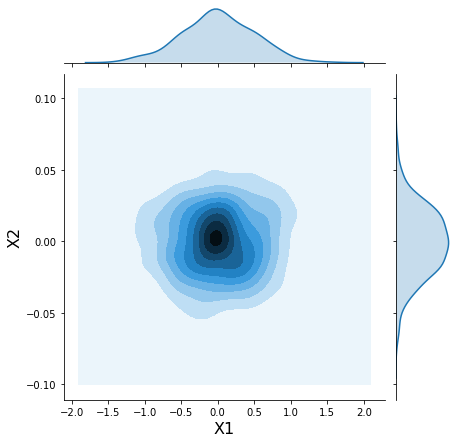

In [56]:
h = sns.jointplot(df_sample_norm.iloc[1][:, 7], df_sample_norm.iloc[1][:, 129], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

In [57]:
df_sample_norm = expand_df(df_sample_norm, cols_mean)

In [58]:
df_sample_norm.head(5)

,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_NT,Province_ON,Province_PE,Province_QC,...,"Family Income_$40,000 to $44,999","Family Income_$45,000 to $49,999","Family Income_$5,000 to $9,999","Family Income_$50,000 to $59,999","Family Income_$60,000 to $69,999","Family Income_$70,000 to $79,999","Family Income_$80,000 to $89,999","Family Income_$90,000 to $99,999","Family Income_Under $5,000",Mean
PostCode,,,,,,,,,,,,,,,,,,,,,
A0A1A0,0.709766,-0.147826,-0.118811,-0.040169,1.103398,0.236471,0.021354,-0.021572,-0.044493,-0.477941,...,0.135256,0.124054,0.075797,0.092630,0.030830,0.074374,0.062361,-0.005628,-0.000443,15.133324
A0A1A0,-0.194166,-0.030080,0.009916,-0.088911,0.971101,-0.223149,0.017777,-0.345359,0.036025,0.832788,...,0.082524,0.129744,-0.015272,0.103513,0.008384,0.089607,0.079977,0.048063,-0.041440,15.802769
A0A1A0,0.162504,0.557826,-0.360194,0.088178,1.290973,-0.158498,-0.031075,-1.183003,0.106331,0.278447,...,0.053536,0.079307,0.014430,0.104953,0.029166,0.122176,0.063071,0.040022,-0.002608,16.074398
A0A1A0,0.837916,-0.388389,-0.266451,-0.186606,0.910013,-0.370553,-0.008947,0.221495,-0.003594,0.115807,...,0.155117,0.126495,0.009147,0.062580,0.029928,0.099464,0.082480,0.068485,-0.004960,11.816479
A0A1A0,-0.544574,0.010673,0.010167,0.229068,0.972476,0.126831,-0.010328,0.161656,-0.045236,-0.311207,...,0.107621,0.087175,-0.000490,0.121309,0.082377,0.037811,0.049240,0.055368,0.000577,15.655582


## 4.2 Uniformify Marginal Distribution

In [59]:
# Normalize continuous category
df_sample_norm["Mean"] = df_sample_norm["Mean"].groupby("PostCode").apply(
    lambda x: (x - x.mean()) / df_merged.loc[x.index[0]]["Std"]
)

In [60]:
df_sample_norm["Mean"].head()

PostCode
A0A1A0    0.106262
A0A1A0    0.171490
A0A1A0    0.197956
A0A1A0   -0.216918
A0A1A0    0.157149
Name: Mean, dtype: float64

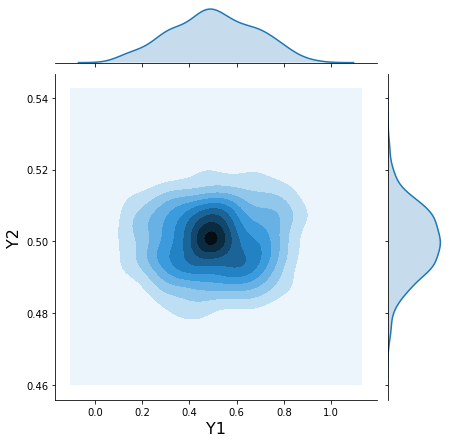

In [61]:
norm = stats.norm()
df_sample_unif = df_sample_norm.groupby("PostCode").apply(norm.cdf)
h = sns.jointplot(df_sample_unif.iloc[1][:, 7], df_sample_unif.iloc[1][:, 129], kind='kde', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

In [62]:
df_sample_unif = expand_df(df_sample_unif, cols_mean)

In [63]:
df_sample_unif.head()

,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_NT,Province_ON,Province_PE,Province_QC,...,"Family Income_$40,000 to $44,999","Family Income_$45,000 to $49,999","Family Income_$5,000 to $9,999","Family Income_$50,000 to $59,999","Family Income_$60,000 to $69,999","Family Income_$70,000 to $79,999","Family Income_$80,000 to $89,999","Family Income_$90,000 to $99,999","Family Income_Under $5,000",Mean
PostCode,,,,,,,,,,,,,,,,,,,,,
A0A1A0,0.761075,0.441240,0.452713,0.483979,0.865073,0.593466,0.508518,0.491395,0.482256,0.316346,...,0.553795,0.549364,0.530210,0.536901,0.512297,0.529643,0.524862,0.497755,0.499823,0.542313
A0A1A0,0.423023,0.488002,0.503956,0.464576,0.834251,0.411710,0.507092,0.364912,0.514369,0.797518,...,0.532885,0.551615,0.493908,0.541222,0.503345,0.535700,0.531872,0.519167,0.483472,0.568081
A0A1A0,0.564545,0.711518,0.359351,0.535133,0.901644,0.437032,0.487605,0.118404,0.542340,0.609665,...,0.521348,0.531606,0.505756,0.541793,0.511634,0.548620,0.525145,0.515962,0.498960,0.578460
A0A1A0,0.798961,0.348864,0.394946,0.425985,0.818592,0.355485,0.496431,0.587647,0.498566,0.546097,...,0.561636,0.550330,0.503649,0.524950,0.511938,0.539615,0.532867,0.527300,0.498021,0.414136
A0A1A0,0.293023,0.504258,0.504056,0.590592,0.834593,0.550463,0.495880,0.564212,0.481960,0.377822,...,0.542852,0.534734,0.499805,0.548277,0.532827,0.515081,0.519636,0.522077,0.500230,0.562436


## 4.3 Convert Uniform Distribution into Desired Marginal Distribution Using Inverse Cumulative Distribution Function (CDF)
Use inverse Cumulative Distribution Function (CDF) of the marginal distribution for the conversion, and in our case, assume all the categorical variables follow beta distribution, and all continuous variables follow lognormal distribution.

### 4.3.1 Continuous Data Conversion

In [64]:
cols_continuous = cols_mean[130]

In [65]:
df_sample_lognorm = df_sample_unif[cols_continuous].groupby("PostCode").apply(
    lambda x: stats.lognorm([df_merged.loc[x.index[0]]["Std"]], loc=df_merged.loc[x.index[0]]["Mean"]).ppf(x),
)

In [66]:
df_sample_lognorm = df_sample_lognorm.explode().apply(int)
df_sample_lognorm.head()

PostCode
A0A1A0    17
A0A1A0    19
A0A1A0    21
A0A1A0    14
A0A1A0    19
Name: Mean, dtype: int64

(0, 0.3)

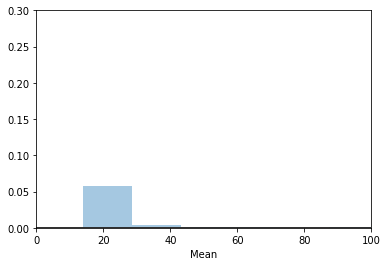

In [67]:
h = sns.distplot(df_sample_lognorm.loc["A0A1A0"], kde=False, fit=stats.lognorm)
h.set_xlim(0, 100)
h.set_ylim(0, 0.3)

### 4.3.2 Categorical Data Conversion

In [68]:
cols_categorical = cols_mean[:130]

In [69]:
beta = stats.beta(a=1, b=1)
df_sample_beta = df_sample_unif[cols_categorical].groupby("PostCode").apply(beta.ppf)

In [70]:
df_sample_beta = expand_df(df_sample_beta, cols_categorical)
df_sample_beta.head()

,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_NT,Province_ON,Province_PE,Province_QC,...,"Family Income_$35,000 to $39,999","Family Income_$40,000 to $44,999","Family Income_$45,000 to $49,999","Family Income_$5,000 to $9,999","Family Income_$50,000 to $59,999","Family Income_$60,000 to $69,999","Family Income_$70,000 to $79,999","Family Income_$80,000 to $89,999","Family Income_$90,000 to $99,999","Family Income_Under $5,000"
PostCode,,,,,,,,,,,,,,,,,,,,,
A0A1A0,0.761075,0.441240,0.452713,0.483979,0.865073,0.593466,0.508518,0.491395,0.482256,0.316346,...,0.516365,0.553795,0.549364,0.530210,0.536901,0.512297,0.529643,0.524862,0.497755,0.499823
A0A1A0,0.423023,0.488002,0.503956,0.464576,0.834251,0.411710,0.507092,0.364912,0.514369,0.797518,...,0.512180,0.532885,0.551615,0.493908,0.541222,0.503345,0.535700,0.531872,0.519167,0.483472
A0A1A0,0.564545,0.711518,0.359351,0.535133,0.901644,0.437032,0.487605,0.118404,0.542340,0.609665,...,0.519221,0.521348,0.531606,0.505756,0.541793,0.511634,0.548620,0.525145,0.515962,0.498960
A0A1A0,0.798961,0.348864,0.394946,0.425985,0.818592,0.355485,0.496431,0.587647,0.498566,0.546097,...,0.516342,0.561636,0.550330,0.503649,0.524950,0.511938,0.539615,0.532867,0.527300,0.498021
A0A1A0,0.293023,0.504258,0.504056,0.590592,0.834593,0.550463,0.495880,0.564212,0.481960,0.377822,...,0.528122,0.542852,0.534734,0.499805,0.548277,0.532827,0.515081,0.519636,0.522077,0.500230


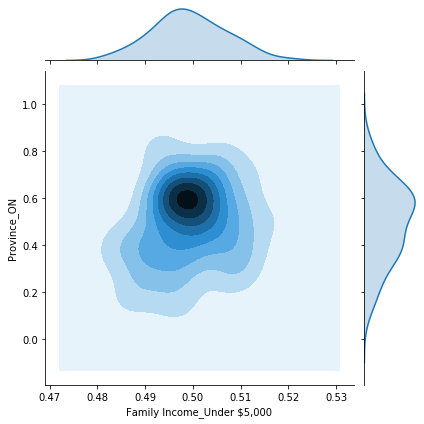

In [71]:
h = sns.jointplot(
    df_sample_beta.loc["A0A1A0"]["Family Income_Under $5,000"], 
    df_sample_beta.loc["A0A1A0"]["Province_ON"],
    kind='kde', 
    stat_func=None
)

### 4.3.3 Class Assignment with Multinomial Distribution

In [72]:
category_indices = defaultdict(list)
classes = defaultdict(list)
cols_class = [col.split("_") for col in list(df_sample_beta.columns)]
for ind, col in enumerate(cols_class):
    category_indices[col[0]].append(ind)
    classes[col[0]].append(col[1])
categories = [category for category in category_indices.keys()]

In [73]:
df_sample_cate_merge = pd.DataFrame()
for col, ind in category_indices.items():
    df_sample_cate_merge[col] = df_sample_beta[df_sample_beta.columns[ind]].values.tolist()


In [74]:
df_sample_cate_merge.head()

,Province,Age,Gender,Ethnicity,Religion,Language,Immigration,Commute,Marital Status,Family Size,Dwelling,Ownership,Education,Profession,Income,Family Income
0,"[0.7610754629442888, 0.4412398617489654, 0.452...","[0.49762885686370995, 0.5287283991752336, 0.52...","[0.6725532746935046, 0.7098770237060339]","[0.5036656061500584, 0.4987284154377794, 0.764...","[0.4947502212065835, 0.8483224460162322, 0.492...","[0.9217890799937941, 0.38128569902216164, 0.45...","[0.5284679540709252, 0.8234467960895967]","[0.506698422091469, 0.7018724165343135, 0.5388...","[0.5473923995861228, 0.5264990791381964, 0.701...","[0.7115520768818182, 0.6478585355942927, 0.540...","[0.5015309949305331, 0.629459594858861, 0.7472...","[0.7164104865514698, 0.6655976049735375]","[0.49929469896953366, 0.5356520683444044, 0.68...","[0.5154230455661908, 0.505137222532577, 0.5436...","[0.583917241969826, 0.5120933906237255, 0.5159...","[0.5224334067640792, 0.5183334297732985, 0.501..."
1,"[0.4230230555958813, 0.4880016108044333, 0.503...","[0.5053268145174447, 0.5106190802637386, 0.521...","[0.7083801973829078, 0.6741281757296091]","[0.47744754277667484, 0.4868870836567513, 0.59...","[0.48965450780066705, 0.8859056647698966, 0.50...","[0.6712499922856898, 0.6943593980557391, 0.519...","[0.532789372378926, 0.820616374111876]","[0.48600523045191857, 0.8081676313787608, 0.53...","[0.5198834933824346, 0.5691972454492187, 0.743...","[0.6216676553645305, 0.6211600850762926, 0.568...","[0.4796819389398228, 0.6150190380121728, 0.775...","[0.8945549215678358, 0.40086014111695484]","[0.5109768782806781, 0.5610393213423822, 0.643...","[0.4997002760600706, 0.4700206436914255, 0.560...","[0.5259364212775901, 0.5129098524547796, 0.510...","[0.502053319336017, 0.5764473376492063, 0.5648..."
2,"[0.5645453396108253, 0.7115184043661802, 0.359...","[0.500044613377006, 0.5136155172993354, 0.5099...","[0.6402892024277642, 0.7391633336390996]","[0.4823721807549526, 0.48532235756425607, 0.70...","[0.5006378414157452, 0.854678094669393, 0.5028...","[0.7927189260924862, 0.618592972079024, 0.4531...","[0.4527779506446094, 0.8683544098031586]","[0.4926501158957524, 0.807221041017255, 0.5141...","[0.509565320840654, 0.552277421417141, 0.75432...","[0.6648431099742323, 0.6558117689080302, 0.546...","[0.4778643505474987, 0.5691525925137048, 0.810...","[0.8171281319228555, 0.5380512861463939]","[0.5294310600725097, 0.5231365846564311, 0.664...","[0.5233643207081313, 0.4912430375032035, 0.576...","[0.5326098239647499, 0.5211073239988121, 0.516...","[0.5168290656571644, 0.529302284356637, 0.5473..."
3,"[0.7989609650193805, 0.3488641292395638, 0.394...","[0.5096223298642074, 0.519353700314123, 0.5544...","[0.6711040815314985, 0.7112486217660755]","[0.539402357748889, 0.524645288242518, 0.67566...","[0.5182109242409781, 0.8240159284587478, 0.498...","[0.859760599201046, 0.45819023330132724, 0.510...","[0.5272125681356286, 0.8242633280442315]","[0.48229716627270763, 0.7910720033489431, 0.50...","[0.5313371839239309, 0.5221891176636165, 0.676...","[0.6962850854706109, 0.606256247197771, 0.5375...","[0.4789972610559683, 0.4603904946000862, 0.875...","[0.7471464092316358, 0.6309850007388446]","[0.5500208072711219, 0.45762311808707323, 0.73...","[0.5324775467762954, 0.5170254826054645, 0.547...","[0.591709662875664, 0.5193787065758839, 0.4915...","[0.5050714015539834, 0.520028676390414, 0.5195..."
4,"[0.29302326658512967, 0.5042579319339908, 0.50...","[0.5349240434958763, 0.503833562377409, 0.5192...","[0.7020002492312539, 0.680764571191088]","[0.5420691043830307, 0.46042147884762913, 0.66...","[0.5169678707250939, 0.8279321177311676, 0.496...","[0.8452639503208752, 0.5115662743859507, 0.481...","[0.4814294890506788, 0.8523501489661781]","[0.5024491126971427, 0.8016655772142965, 0.513...","[0.501878360185106, 0.5441914845853008, 0.6797...","[0.6550958288659061, 0.5990539404771119, 0.539...","[0.5016866308251751, 0.2755246307794307, 0.944...","[0.7828899521360762, 0.5862891957889476]","[0.49609694075572

In [75]:
# Normalize
df_sample_multinomial = df_sample_cate_merge.applymap(
    lambda x: [i / sum(x) for i in x]
)

# Sample from multinomial distribution
df_sample_multinomial = df_sample_multinomial.applymap(
    lambda x: stats.multinomial.rvs(100, x)
)

# Get the argmax
df_sample_multinomial = df_sample_multinomial.applymap(np.argmax)

# Get the class from the argmax.
df_sample_category = pd.DataFrame()
for col, cls in classes.items():
    df_sample_category[col] = df_sample_multinomial[col].apply(lambda x: cls[x])
    
df_sample_category = df_sample_category.set_index(df_sample_beta.index) 

In [76]:
df_sample_category.head()

,Province,Age,Gender,Ethnicity,Religion,Language,Immigration,Commute,Marital Status,Family Size,Dwelling,Ownership,Education,Profession,Income,Family Income
PostCode,,,,,,,,,,,,,,,,
A0A1A0,BC,60 to 64 years,Male,Aboriginal,Christian,English,Native,Car (driver),Never married,2 persons,Single-detached house,Owned,College,Manufacturing,"$150,000 and over","$150,000 to $199,999"
A0A1A0,NL,55 to 59 years,Male,"Latin, Central and South American",Christian,English,Native,Other method,Married,1 person,Single-detached house,Owned,Bachelor's degree or above,Real estate and rental and leasing,"$10,000 to $19,999","$100,000 to $124,999"
A0A1A0,NL,65 years and over,Male,British,Christian,English,Native,Car (driver),Married,2 persons,Single-detached house,Owned,Secondary school,Health care and social assistance,"$80,000 to $89,999","$60,000 to $69,999"
A0A1A0,NL,60 to 64 years,Female,North American,Christian,English,Native,Car (driver),Never married,1 person,Single-detached house,Owned,"No certificate, diploma or degree",Health care and social assistance,"$60,000 to $69,999","$45,000 to $49,999"
A0A1A0,NL,60 to 64 years,Male,British,Christian,English,Native,Bicycle,Never married,1 person,Single-detached house,Owned,"No certificate, diploma or degree","Administrative and support, waste management a...","$60,000 to $69,999","$150,000 to $199,999"


In [77]:
df_synthetic = df_sample_category
df_synthetic["Number of Trade"] = df_sample_lognorm

In [78]:
df_synthetic.head()

,Province,Age,Gender,Ethnicity,Religion,Language,Immigration,Commute,Marital Status,Family Size,Dwelling,Ownership,Education,Profession,Income,Family Income,Number of Trade
PostCode,,,,,,,,,,,,,,,,,
A0A1A0,BC,60 to 64 years,Male,Aboriginal,Christian,English,Native,Car (driver),Never married,2 persons,Single-detached house,Owned,College,Manufacturing,"$150,000 and over","$150,000 to $199,999",17
A0A1A0,NL,55 to 59 years,Male,"Latin, Central and South American",Christian,English,Native,Other method,Married,1 person,Single-detached house,Owned,Bachelor's degree or above,Real estate and rental and leasing,"$10,000 to $19,999","$100,000 to $124,999",19
A0A1A0,NL,65 years and over,Male,British,Christian,English,Native,Car (driver),Married,2 persons,Single-detached house,Owned,Secondary school,Health care and social assistance,"$80,000 to $89,999","$60,000 to $69,999",21
A0A1A0,NL,60 to 64 years,Female,North American,Christian,English,Native,Car (driver),Never married,1 person,Single-detached house,Owned,"No certificate, diploma or degree",Health care and social assistance,"$60,000 to $69,999","$45,000 to $49,999",14
A0A1A0,NL,60 to 64 years,Male,British,Christian,English,Native,Bicycle,Never married,1 person,Single-detached house,Owned,"No certificate, diploma or degree","Administrative and support, waste management a...","$60,000 to $69,999","$150,000 to $199,999",19
